# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator
from PIL import Image
import os

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [3]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# First use "accelerate config" in terminal and setup using deepspeed stage 2 with CPU offloading!
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
if utils.is_interactive(): # set batch size here if using interactive notebook instead of submitting job
    global_batch_size = batch_size = 8
else:
    global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices


LOCAL RANK  0


In [4]:
print(num_devices)

2


In [5]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 253038
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [ ]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "eeg_multisubject_fmri_init"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the 2nd cell block
    jupyter_args = f"--data_path=/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/data \
--model_name={model_name} \
--subj=2 \
--blurry_recon \
--batch_size=16 \
--max_lr=3e-4 \
--mixup_pct=.33 \
--num_epochs=2 \
--use_prior \
--prior_scale=30 \
--clip_scale=1 \
--blur_scale=.5 \
--no-use_image_aug \
--n_blocks=4 \
--hidden_dim=1024 \
--ckpt_interval=1 \
--ckpt_saving \
--preprocessing_method=THINGSEEG2 \
--fmri_ckpt=/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/multisubject_subj01_1024hid_nolow_300ep"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: eeg_multisubject_fmri_init
--data_path=/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/data --model_name=eeg_multisubject_fmri_init --subj=2 --blurry_recon --batch_size=16 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=2 --use_prior --prior_scale=30 --clip_scale=1 --blur_scale=.5 --no-use_image_aug --n_blocks=4 --hidden_dim=1024 --ckpt_interval=1 --ckpt_saving --preprocessing_method=THINGSEEG2 --multisubject_ckpt=/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/multisubject_subj01_1024hid_nolow_300ep


In [ ]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8,9,10],
    help="Validate on which subject?",
)
parser.add_argument(
    "--eeg_ckpt", type=str, default=None,
    help="Path to pre-trained eeg to image model to finetune a single subject from. ",
)
parser.add_argument(
    "--fmri_ckpt", type=str, default=None,
    help="Path to pre-trained fmri to image model to finetune a eeg to image model from. ",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=True,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--batch_size", type=int, default=16,
    help="Batch size can be increased by 10x if only training retreival submodule and not diffusion prior",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=150,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--preprocessing_method",type=str,default="unspecified",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    
if multi_subject:
    subj_list = np.arange(1,11)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list)

subj_list [2]


# Prep data, models, and dataloaders

### Prepare DataLoader

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

class Data4Model(torch.utils.data.Dataset):
    def __init__(self, state='training', sub_id=1, transform=None):
        
        super(Data4Model, self).__init__()
       
        imgs = np.load(f'{data_path}/GetData/'+state+'_imgpaths.npy').tolist()
        
        eeg = np.load(f'{data_path}/PreprocessedEEG/sub-'+str(sub_id).zfill(2)+'/preprocessed_eeg_'+state+'.npy', allow_pickle=True).tolist()
        eeg = eeg['preprocessed_eeg_data']
        eeg = np.mean(eeg, axis=1)
        
        self.imgs = imgs
        self.eeg = torch.Tensor(eeg).to('cpu').to(data_type)
        self.transform = transform
  
    def __len__(self):
        return min(len(self.imgs), len(self.eeg))
    
    def __getitem__(self, item):
        imgs = self.transform(Image.open(self.imgs[item]).convert('RGB'))
        eeg = torch.tensor(self.eeg[item], dtype=data_type)
        return eeg, imgs

In [9]:
from torch.utils.data import DataLoader
num_test = 200
num_train = 16540

train_dls = []
test_dls = []

for sub_id in subj_list:

    train_data = Data4Model(state='training', sub_id=sub_id, transform=transform)
    train_dl = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    test_data = Data4Model(state='test', sub_id=sub_id, transform=transform)
    test_dl = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    
    train_dls.append(train_dl)
    test_dls.append(test_dl)
    
    print(f"Loaded test and train dl for subject {sub_id}!\n")
    print(f"test cases: {len(test_data)} and train cases: {len(train_data)}\n")

Loaded test and train dl for subject 2!

test cases: 200 and train cases: 16540



## Load models

### CLIP image embeddings  model

In [10]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/fmri/lib64/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### SD VAE

In [11]:
from huggingface_hub import hf_hub_download

if blurry_recon:
    from diffusers import AutoencoderKL    
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    # Download the Autoencoder checkpoint from Hugging Face
    autoenc_ckpt_path = hf_hub_download(repo_id='pscotti/mindeyev2', filename='sd_image_var_autoenc.pth', repo_type='dataset')
    ckpt = torch.load(autoenc_ckpt_path)
    autoenc.load_state_dict(ckpt)
    
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)
    
    from autoencoder.convnext import ConvnextXL
    # Download ConvnextXL checkpoint from Hugging Face
    cnx_ckpt_path = hf_hub_download(repo_id='pscotti/mindeyev2', filename='convnext_xlarge_alpha0.75_fullckpt.pth', repo_type='dataset')
    cnx = ConvnextXL(cnx_ckpt_path)
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(device)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(device).reshape(1,3,1,1)
    
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )


param counts:
83,653,863 total
0 trainable


/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/fmri/lib64/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### MindEye modules

In [12]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [13]:
from models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, n_blocks=n_blocks,
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, 
                          blurry_recon=blurry_recon, clip_scale=clip_scale)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
458,885,116 total
458,885,116 trainable
param counts:
458,885,116 total
458,885,116 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [14]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = PriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb",
            rotary_emb=False
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
259,865,200 total
259,865,200 trainable
param counts:
718,750,316 total
718,750,316 trainable


## Transfer from fMRI to EEG

### Check eeg input shape

In [15]:
eeg_example = next(iter(train_dls[0]))
eeg_example = np.array(eeg_example[0])
print("EEG shape ", eeg_example.shape)
eeg_input_dim = eeg_example[0].flatten().shape[0]
print("eeg_input_dim ", eeg_input_dim)
print("hidden_dim", hidden_dim)

EEG shape  (16, 63, 100)
eeg_input_dim  6300
hidden_dim 1024


/net/tscratch/people/plgkzrobek/slurm_jobdir/1115225/tmp.t0014/ipykernel_253038/3872812553.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg = torch.tensor(self.eeg[item], dtype=data_type)


### Ridge Regression

In [16]:
# #For EEG training with latent space preinitialized by fMRI based model
num_voxels_list = [ 15724, 15226, 13153, 13039, 17907, 12682, 14386, 15724, 15724, 15724] # fmri voxels dimentions for original MindEyeV2 Model
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out
        

# # For EEG training without preinitialized latent space
class RidgeRegressionEEG(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_size, out_features): 
        super(RidgeRegressionEEG, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        out = self.linear(x[:,0]).unsqueeze(1)
        return out



### Load checkpoint
If fmri model checkpoint is specified replace original Ridge Regression (for fMRI input) with Ridge for EEG input

In [17]:
def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

In [ ]:
# load multisubject stage1 ckpt if set
if fmri_ckpt is not None:
    model.ridge = RidgeRegression(num_voxels_list, out_features=1024)
    utils.count_params(model.ridge)
    utils.count_params(model)
    
    load_ckpt("last",outdir=fmri_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

    
# Replace with new trainable ridge in case of checkpoint
# Create new model component in case of no checkpoint
model.ridge = RidgeRegressionEEG(eeg_input_dim, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)
b = torch.randn((2,1,eeg_input_dim))
print(b.shape, model.ridge(b).shape)


param counts:
152,882,176 total
152,882,176 trainable
param counts:
871,632,492 total
871,632,492 trainable

---loading /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth ckpt---

[2024-12-12 22:47:21,629] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
param counts:
6,452,224 total
6,452,224 trainable
param counts:
725,202,540 total
725,202,540 trainable
torch.Size([2, 1, 6300]) torch.Size([2, 1, 1024])


In [ ]:
# Load EEG model from chekcpoint if specified
if eeg_ckpt is not None:
    load_ckpt("last",outdir=eeg_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)


### Setup optimizer / lr / ckpt saving

In [19]:
num_samples_per_epoch = num_train // num_devices 

num_iterations_per_epoch = num_samples_per_epoch // (batch_size)

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

batch_size = 16 num_iterations_per_epoch = 1033 num_samples_per_epoch = 16540


In [20]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")


print("\nDone with model preparations!")
num_params = utils.count_params(model)

accumulation_steps = 8

total_steps 2066

Done with model preparations!
param counts:
725,202,540 total
725,202,540 trainable


# Weights and Biases

In [21]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeye'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "num_train": num_train,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "preprocessing_method": preprocessing_method
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Main

In [22]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [23]:
model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [24]:
print(model)

MindEyeModule(
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1024, out_features=1024, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linear(in_features=1024, out_features=425984, bias=True)
    (clip_proj): Sequential(
      (0): LayerNorm((1664,), eps=1e-05, elementwise_

## Training Loop

In [42]:
print("Number of Epochs planned: ", num_epochs)

Number of Epochs planned:  100


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

epoch 44 / 100



  0%|          | 0/12 [00:00<?, ?it/s]/net/tscratch/people/plgkzrobek/slurm_jobdir/1115225/tmp.t0014/ipykernel_253038/3872812553.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg = torch.tensor(self.eeg[item], dtype=data_type)
  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

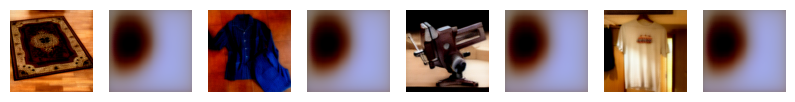

  2%|████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/56 [00:13<12:06, 13.20s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 45 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

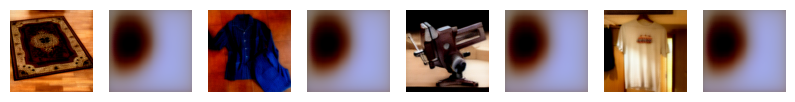

  4%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/56 [00:26<12:07, 13.48s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 46 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

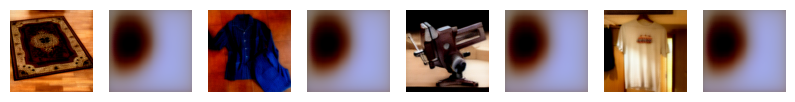

  5%|█████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 3/56 [00:40<11:56, 13.52s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 47 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...

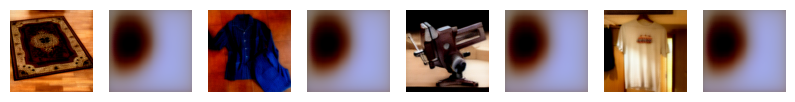

  7%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 4/56 [00:53<11:33, 13.34s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 48 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

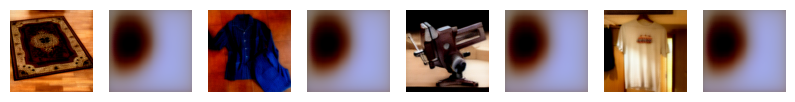

  9%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 5/56 [01:06<11:15, 13.24s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 49 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...

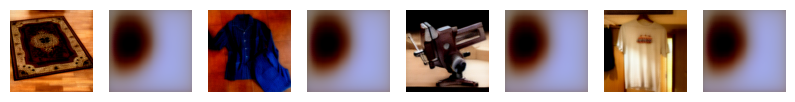

 11%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 6/56 [01:19<10:56, 13.12s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 50 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...

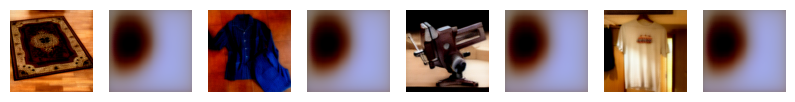

 12%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 7/56 [01:33<10:55, 13.37s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 51 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[  0.5239, -14.9609,   8.7188,  ...

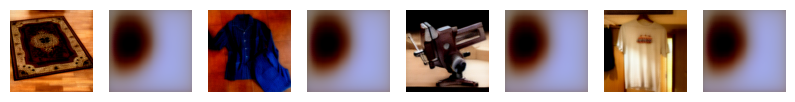

 14%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 8/56 [01:46<10:45, 13.44s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw


---saved /net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/train_logs/eeg_multisubject_fmri_init/last ckpt!---

epoch 52 / 100



  0%|          | 0/12 [00:00<?, ?it/s]

tensor([[[     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         ...,
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan],
         [     nan,      nan,      nan,  ...,      nan,      nan,      nan]],

        [[ -0.5474, -11.1328,   8.7891,  ...,  10.2031, -11.7188,  -9.3047],
         [  0.0681,  -9.5391,   7.4258,  ...,   8.6328, -10.0000,  -7.7500],
         [ -0.3220, -10.6406,   8.3359,  ...,   9.7188, -11.1719,  -8.8047],
         ...,
         [  0.0436, -12.1172,   8.7109,  ...,  11.0625, -12.3906,  -9.6953],
         [  1.3799,   1.0059,  -0.1442,  ...,  -1.0068,   0.1886,   1.0723],
         [  0.4111,  -7.7461,   5.9609,  ...,   6.9414,  -8.2031,  -6.2461]],

        [[     nan,      nan,      nan,  ...

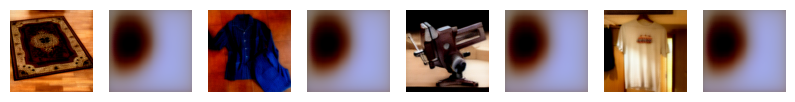

 14%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 8/56 [01:58<11:53, 14.87s/it, test/blurry_pixcorr=0, test/loss=nan, test/loss_clip_total=0, test/loss_prior=nan, test/num_steps=0, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0, test/test_fwd_pct_correct=0, train/blurry_pixcorr=0, train/bwd_pct_correct=0, train/fw

In [ ]:
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_eeg = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
accumulation_steps = 8

for epoch in progress_bar:
    print(f"epoch {epoch} / {num_epochs}")
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.
    
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.
    
    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1
    
    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    eeg_iters = {}
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224)
    annot_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    train_i=0
    for s, train_dl in enumerate(train_dls):
        print(f"SUBJECT {subj_list[s]}")
        with torch.cuda.amp.autocast(dtype=data_type):
            for eeg, imgs in tqdm(train_dl): 
                train_i += 1

                # Load images 
                if epoch < int(mixup_pct * num_epochs):
                    eeg, perm, betas, select = utils.mixco(eeg)

                optimizer.zero_grad()
                loss=0.
        
                eeg = eeg.detach().to(device) 
                image = imgs.detach().to(device)
        
                if use_image_aug: 
                    image = img_augment(imgs)
        
                clip_target = clip_img_embedder(image)
                assert not torch.any(torch.isnan(clip_target))
        
                if epoch < int(mixup_pct * num_epochs):
                    perm = perm.detach().to(device)
                    betas = betas.detach().to(device)
                    select = select.detach().to(device)

                eeg_ridge = model.module.ridge(eeg.view(batch_size,-1).unsqueeze(1)) 
                
                backbone, clip_eegs, blurry_image_enc_ = model.module.backbone(eeg_ridge)
        
                if clip_scale>0:
                    clip_eegs_norm = nn.functional.normalize(clip_eegs.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
        
                if use_prior:
                    loss_prior, prior_out = model.module.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
        
                    recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                    recon_mse += mse(prior_out, clip_target).item()
                if clip_scale>0:
                    if epoch < int(mixup_pct * num_epochs):    
                        loss_clip = utils.mixco_nce(
                            clip_eegs_norm,
                            clip_target_norm,
                            temp=.006,
                            perm=perm, betas=betas, select=select)
                    else:
                        epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                        loss_clip = utils.soft_clip_loss(
                            clip_eegs_norm,
                            clip_target_norm,
                            temp=epoch_temp)
                    loss_clip_total += loss_clip.item()
                    loss_clip *= clip_scale
                    loss += loss_clip
                
                    
                if blurry_recon:     
                    image_enc_pred, transformer_feats = blurry_image_enc_
        
                    image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                    loss_blurry = l1(image_enc_pred, image_enc)
                    loss_blurry_total += loss_blurry.item()
        
                    if epoch < int(mixup_pct * num_epochs):
                        image_enc_shuf = image_enc[perm]
                        betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                        # Ensure all tensors have the same dtype as `image_enc`
                        image_enc[select] = image_enc[select].half() * betas[select].half().reshape(*betas_shape) + \
                            image_enc_shuf[select].half() * (1 - betas[select].half()).reshape(*betas_shape)
        
                    image_norm = (image - mean)/std
                    image_aug = (blur_augs(image) - mean)/std
                    _, cnx_embeds = cnx(image_norm)
                    _, cnx_aug_embeds = cnx(image_aug)
        
                    cont_loss = utils.soft_cont_loss(
                        nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                        nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                        nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                        temp=0.2)
                    loss_blurry_cont_total += cont_loss.item()
        
                    loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215
        
                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_eegs_norm)).to(clip_eegs_norm.device) 
                    fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_eegs_norm, clip_target_norm), labels, k=1).item()
                    bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_eegs_norm), labels, k=1).item()
        
                if blurry_recon:
                    with torch.no_grad():
                        # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                        random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                        blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                        pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                        blurry_pixcorr += pixcorr.item()
                
                if utils.check_loss(loss) == False:
                    print(f"\tNAN LOSS in TRAIN! continuing")
                    train_i -=1
                    continue  
                    
                accelerator.backward(loss)
                
                if (train_i) % accumulation_steps == 0:
                    for param in model.parameters():
                        if(param.grad == None):
                            print("Gradient exploded")
                            continue
                        param.grad /= accumulation_steps
                    optimizer.step()
                    for param in model.parameters():
                        if(param.grad == None):
                            continue
                        param.grad.zero_()
        
                losses.append(loss.item())
                lrs.append(optimizer.param_groups[0]['lr'])
                

                if lr_scheduler_type is not None:
                    lr_scheduler.step()

                
    model.eval()
    
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            test_i = 0
            for test_dl in test_dls:
                for eeg, imgs in tqdm(test_dl):  
                    test_i += 1
                    test_eeg = eeg.detach().to(device)
                    test_image = imgs.detach().to(device)
                    loss=0.
        
                    clip_target = clip_img_embedder(test_image)
                    for rep in range(3):
                        eeg_ridge = model.module.ridge(test_eeg.view(batch_size,-1).unsqueeze(1)) # 0th index of subj_list
                        backbone0, clip_eegs0, blurry_image_enc_ = model.module.backbone(eeg_ridge)
                        if rep==0:
                            clip_eegs = clip_eegs0
                            backbone = backbone0
                        else:
                            clip_eegs += clip_eegs0
                            backbone += backbone0
                    clip_eegs /= 3
                    backbone /= 3
        
                    if clip_scale>0:
                        clip_eegs_norm = nn.functional.normalize(clip_eegs.flatten(1), dim=-1)
                        clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                    
                    # for some evals, only doing a subset of the samples per batch because of computational cost
                    random_samps = np.random.choice(np.arange(len(test_image)), size=len(test_image)//5, replace=False)
                    
                    if use_prior:
                        loss_prior, contaminated_prior_out = model.module.diffusion_prior( text_embed=backbone, image_embed=clip_target)
                        test_loss_prior_total += loss_prior.item()
                        loss_prior *= prior_scale
                        loss += loss_prior
                        
                        
                    if clip_scale>0:
                        loss_clip = utils.soft_clip_loss(
                            clip_eegs_norm,
                            clip_target_norm,
                            temp=.006)
        
                        test_loss_clip_total += loss_clip.item()
                        loss_clip = loss_clip * clip_scale
                        loss += loss_clip
                    
                    if blurry_recon:
                        image_enc_pred, _ = blurry_image_enc_
                        blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                        pixcorr = utils.pixcorr(test_image[random_samps], blurry_recon_images)
                        test_blurry_pixcorr += pixcorr.item()
        
                    if clip_scale>0:
                        # forward and backward top 1 accuracy        
                        labels = torch.arange(len(clip_eegs_norm)).to(clip_eegs_norm.device) 
                        test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_eegs_norm, clip_target_norm), labels, k=1).item()
                        test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_eegs_norm), labels, k=1).item()
                    
                    if utils.check_loss(loss) == False:
                        print(f"\tNAN LOSS in TEST! continuing")
                        test_i -=1
                        continue             
                    test_losses.append(loss.item())
    
                    
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }
    
            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*test_image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
    
                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
                
            progress_bar.set_postfix(**logs)
    
            if wandb_log: wandb.log(logs)
            
       
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')
    
    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache() 
    
print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')    

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

In [47]:
for name, param in model.diffusion_prior.named_parameters():
    if param.grad is not None:  # Check if the gradient exists
        print(f"===========\nParameter: {name}\n----------\nGradient: {param.grad}")
    else:
        print(f"===========\nParameter: {name}\n----------\nGradient: None (not computed)")

Parameter: net.learned_query
----------
Gradient: tensor([[-0.3269, -0.3145,  0.4318,  ...,  0.0263, -0.4350, -0.2939],
        [ 0.4913,  0.0926, -0.4297,  ...,  0.0904, -0.1364,  0.1271],
        [-0.1683, -0.3817,  0.3057,  ..., -0.1730, -0.0865, -0.1908],
        ...,
        [-0.5527, -0.3290,  0.6190,  ..., -0.0385, -0.2585, -0.3690],
        [-1.0373, -0.4421,  1.0941,  ..., -0.3077, -0.4291, -0.8426],
        [-0.5739, -0.2730,  0.9673,  ...,  0.2031, -0.4550, -1.1044]],
       device='cuda:0')
Parameter: net.null_brain_embeds
----------
Gradient: tensor([[-1.1307e-02, -1.2102e-03,  7.0038e-03,  ..., -1.2188e-03,
          3.2158e-03, -5.0354e-03],
        [-4.8866e-03,  1.6785e-03,  7.1564e-03,  ..., -2.2936e-04,
          1.7529e-03, -4.5662e-03],
        [-1.2388e-03, -1.1766e-04,  2.3727e-03,  ..., -1.6918e-03,
         -1.9417e-03, -3.9825e-03],
        ...,
        [-3.3531e-03,  1.3294e-03,  6.4373e-06,  ..., -1.7452e-03,
         -6.5851e-04, -4.1618e-03],
        [-6.5